# Churn

# 1 - Import useful modules

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# 2 - Load and prepare dataset

In [2]:
X_train = pd.read_csv('data/bank_data_train.csv', index_col='ID')

Y_train = X_train.pop('TARGET')

In [3]:
# Drop columns that only have one unique value
useless_cols = [col for col in X_train.columns if len(pd.Series(X_train[col].unique()).dropna()) <= 1]
useless_cols = useless_cols
X_train.drop(columns=useless_cols, inplace=True)

Lower case categorical columns to avoid duplicates.

In [4]:
X_train_categorical = X_train.select_dtypes(include=["object_"])
categorical_cols = X_train_categorical.columns
X_train.drop(columns=categorical_cols, inplace=True)
X_train_categorical = X_train_categorical.apply(lambda c: c.str.lower())

Deal with duplicates in the `CLNT_TRUST_RELATION` column by translating Russian terms to their equivalent in English.

In [5]:
ru_to_en = {'друг': 'other', 'мать': 'mother', 'брат': 'brother', 'отец': 'father', 'сестра': 'sister', 'дочь': 'daughter', 'сын': 'son', 'мама': 'mother'}
X_train_categorical['CLNT_TRUST_RELATION'].replace(ru_to_en, inplace=True)
X_train_categorical.describe()

,CLNT_TRUST_RELATION,APP_MARITAL_STATUS,APP_KIND_OF_PROP_HABITATION,CLNT_JOB_POSITION_TYPE,CLNT_JOB_POSITION,APP_DRIVING_LICENSE,APP_EDUCATION,APP_TRAVEL_PASS,APP_CAR,APP_POSITION_TYPE,APP_EMP_TYPE,APP_COMP_TYPE,PACK
count,69421,68234,59361,44781,210811,57257,68104,57257,57256,60545,67362,67362,355190
unique,13,8,5,4,15111,2,12,2,2,4,4,4,12
top,friend,m,so,specialist,директор,n,h,n,n,specialist,private,private,102
freq,24896,32185,28056,25123,24974,36332,44370,52750,32843,36622,59087,59087,116986


Split the training set into a train dataset (80%) and a dev set (20%) with stratification.

In [6]:
Y_train.value_counts() / len(Y_train)

0    0.918565
1    0.081435
Name: TARGET, dtype: float64

In [7]:
X_train, X_dev, X_train_categorical, X_dev_categorical, Y_train, Y_dev = train_test_split(X_train, X_train_categorical, Y_train, test_size=0.2, stratify=Y_train, random_state=1337)

Fill NA values.

In [8]:
medians = X_train.median(numeric_only=True)
X_train.fillna(medians, inplace=True)
X_dev.fillna(medians, inplace=True)

# 3 - Baseline - naive classifier

In [9]:
from sklearn.metrics import roc_auc_score, accuracy_score

Make a simple classifier that always predicts the most frequent class.

In [10]:
class Baseline:
    def __init__(self):
        self.prediction = 0

    def fit(self, X, y):
        classes = set(y)
        frequencies = {cls: (Y_train == cls).sum() for cls in classes}
        self.prediction = max(frequencies, key=frequencies.get)

    def predict(self, X):
        return np.full(X.shape[0], self.prediction)

In [11]:
bsl = Baseline()
bsl.fit(X_train, Y_train)
dev_predictions = bsl.predict(X_dev)

In [12]:
naive_accuracy = accuracy_score(Y_dev, dev_predictions)
naive_auc = roc_auc_score(Y_dev, dev_predictions)
print('Naive classifier AUC:', naive_auc)

Naive classifier AUC: 0.5


Keep a record of our results.

In [13]:
columns = ['Library', 'Algorithm', 'Hyperparameters', 'Accuracy', 'AUC']
results = []
results.append(['-', 'Baseline naive classifier', '-', naive_accuracy, naive_auc])

# 4 - Baseline - Random Forest

Label-encode categorical features.

In [14]:
cjp_categories = X_train_categorical['CLNT_JOB_POSITION'].value_counts().iloc[:15].index

In [15]:
X_train_categorical_encoded = X_train_categorical.astype(pd.CategoricalDtype())
X_dev_categorical_encoded = pd.DataFrame()

In [16]:
X_train_categorical_encoded['CLNT_JOB_POSITION'] = X_train_categorical['CLNT_JOB_POSITION'].astype(pd.CategoricalDtype(cjp_categories))

In [17]:
categories = {}
for col in categorical_cols:
    cat = X_train_categorical_encoded[col].cat.categories
    categories[col] = cat
    X_dev_categorical_encoded[col] = X_dev_categorical[col].astype(pd.CategoricalDtype(categories=cat))
    X_train_categorical_encoded[col] = X_train_categorical_encoded[col].cat.codes
    X_dev_categorical_encoded[col] = X_dev_categorical_encoded[col].cat.codes

In [18]:
del(X_train_categorical)
del(X_dev_categorical)

In [19]:
X_train = pd.concat([X_train, X_train_categorical_encoded], axis=1)
X_dev = pd.concat([X_dev, X_dev_categorical_encoded], axis=1)

In [20]:
del(X_train_categorical_encoded)
del(X_dev_categorical_encoded)

Standardize numerical columns.

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_dev = scaler.transform(X_dev)

We will train a RandomForestClassifier from sklearn and use GridSearchCV to find optimal hyperparameters.

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [23]:
parameter_grid = {'n_estimators': [32, 64, 128],
                  'max_features': ['sqrt', 'log2'],
                  'max_depth': [8, 16, 32]}

rfc = RandomForestClassifier(random_state=1337, n_jobs=-1)
grid_search = GridSearchCV(estimator=rfc, param_grid=parameter_grid, scoring='roc_auc', n_jobs=-1, cv=3, verbose=0)
grid_search.fit(X_train, Y_train)
print('Best parameters found:', grid_search.best_params_)
best_rfc = grid_search.best_estimator_

Best parameters found: {'max_depth': 16, 'max_features': 'sqrt', 'n_estimators': 128}


Calculate dev set predictions.

In [24]:
dev_predictions = best_rfc.predict(X_dev)
dev_predictions_proba = best_rfc.predict_proba(X_dev)[:, 1]

In [25]:
rfc_accuracy = accuracy_score(Y_dev, dev_predictions)
rfc_auc = roc_auc_score(Y_dev, dev_predictions_proba)
print('Random Forest classifier AUC:', rfc_auc)
results.append(['Scikit-learn', 'Random Forest', grid_search.best_params_, rfc_accuracy, rfc_auc])

Random Forest classifier AUC: 0.8323238061715796


# 5 - MLPClassifier

We will use the Multilayer Perceptron classifier from sklearn.

In [26]:
from sklearn.neural_network import MLPClassifier

In [27]:
mlp = MLPClassifier(random_state=1337, verbose=True, hidden_layer_sizes=(50,), max_iter=20)
mlp.fit(X_train, Y_train)

Iteration 1, loss = 0.28523228
Iteration 2, loss = 0.25016409
Iteration 3, loss = 0.24526579
Iteration 4, loss = 0.24166717
Iteration 5, loss = 0.23902816
Iteration 6, loss = 0.23692680
Iteration 7, loss = 0.23458404
Iteration 8, loss = 0.23331242
Iteration 9, loss = 0.23204344
Iteration 10, loss = 0.23110212
Iteration 11, loss = 0.23011958
Iteration 12, loss = 0.22950392
Iteration 13, loss = 0.22876191
Iteration 14, loss = 0.22804118
Iteration 15, loss = 0.22765978
Iteration 16, loss = 0.22705103
Iteration 17, loss = 0.22635885
Iteration 18, loss = 0.22586646
Iteration 19, loss = 0.22547474
Iteration 20, loss = 0.22499168


/Users/mfarhi/miniconda3/envs/42AI-mfarhi/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(50,), max_iter=20, random_state=1337,
              verbose=True)

In [28]:
dev_predictions = mlp.predict(X_dev)
dev_predictions_proba = mlp.predict_proba(X_dev)[:, 1]

In [29]:
mlpc_accuracy = accuracy_score(Y_dev, dev_predictions)
mlpc_auc = roc_auc_score(Y_dev, dev_predictions_proba)
print('MLPClassifier AUC:', mlpc_auc)
results.append(['Scikit-learn', 'Multilayer Perceptron', 'hidden_layer_sizes=(50,), max_iter=15', mlpc_accuracy, mlpc_auc])

MLPClassifier AUC: 0.8041965677348062


# 6 - Keras

Use Keras sequential API to train an MLP. Find optimal hyperparameters using keras_tuner.

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import keras_tuner
import matplotlib.pyplot as plt
print("Tensorflow version " + tf.__version__)
keras.utils.set_random_seed(1337)

2023-06-21 17:03:25.458596: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow version 2.12.0


Use accelerators if possible.

In [31]:
BATCH_SIZE = 512

In [32]:
# Detect and init the TPU/GPU
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    print("No TPUs detected.")
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
print("Number of accelerators: ", strategy.num_replicas_in_sync)

No TPUs detected.
Num GPUs Available:  0
Number of accelerators:  1


In [33]:
INPUT_SHAPE = [X_train.shape[1]]

def build_model(hp):
    with strategy.scope():
        model = keras.Sequential()
        model.add(
            layers.Dense(
                hp.Int("units_1", min_value=50, max_value=1000, step=100),
                activation='relu', input_shape=INPUT_SHAPE
            )
        )
        model.add(
            layers.Dropout(
                hp.Float(f"dropout_rate_1", min_value=0, max_value=0.8, step=0.2)
            )
        )
        for i in range(2, hp.Int("num_hidden_layers", 3, 6) + 1):
            model.add(
                layers.Dense(
                    hp.Int(f"units_{i}", min_value=50, max_value=1000, step=100),
                    activation='relu'
                )
            )
            model.add(
                layers.Dropout(
                    hp.Float(f"dropout_rate_{i}", min_value=0, max_value=0.8, step=0.2)
                )
            )
        model.add(
            layers.Dense(
                1,
                activation='sigmoid'
            )
        )

        learning_rate = hp.Float("lr", min_value=4e-4, max_value=1e-2, sampling="log")
        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=['AUC']
        )
    return model

In [34]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective=keras_tuner.Objective("val_auc", direction="max"),
    max_trials=30,
    executions_per_trial=1,
    overwrite=False,
    directory="./",
    project_name="hyperparameter_tuning",
    seed=1337
)
tuner.search_space_summary()

INFO:tensorflow:Reloading Tuner from ./hyperparameter_tuning/tuner0.json
Search space summary
Default search space size: 14
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 1000, 'step': 100, 'sampling': 'linear'}
dropout_rate_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.8, 'step': 0.2, 'sampling': 'linear'}
num_hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 6, 'step': 1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 1000, 'step': 100, 'sampling': 'linear'}
dropout_rate_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.8, 'step': 0.2, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 1000, 'step': 100, 'sampling': 'linear'}
dropout_rate_3 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.8, 'step': 0.2, 'sampling': 'linear'}
l

In [35]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, min_delta=1e-3, restore_best_weights=True)
tuner.search(X_train, Y_train, validation_data=(X_dev, Y_dev), epochs=100, batch_size=BATCH_SIZE, callbacks=[early_stopping])

INFO:tensorflow:Oracle triggered exit


In [36]:
tuner.results_summary()

Results summary
Results in ./hyperparameter_tuning
Showing 10 best trials
Objective(name="val_auc", direction="max")

Trial 09 summary
Hyperparameters:
units_1: 550
dropout_rate_1: 0.4
num_hidden_layers: 4
units_2: 150
dropout_rate_2: 0.4
units_3: 650
dropout_rate_3: 0.0
lr: 0.0009182999172585798
units_4: 650
dropout_rate_4: 0.2
units_5: 250
dropout_rate_5: 0.6000000000000001
units_6: 750
dropout_rate_6: 0.8
Score: 0.8238749504089355

Trial 25 summary
Hyperparameters:
units_1: 50
dropout_rate_1: 0.2
num_hidden_layers: 4
units_2: 350
dropout_rate_2: 0.8
units_3: 450
dropout_rate_3: 0.4
lr: 0.0007922470985926789
units_4: 650
dropout_rate_4: 0.6000000000000001
units_5: 550
dropout_rate_5: 0.0
units_6: 250
dropout_rate_6: 0.6000000000000001
Score: 0.8225541710853577

Trial 03 summary
Hyperparameters:
units_1: 650
dropout_rate_1: 0.6000000000000001
num_hidden_layers: 3
units_2: 50
dropout_rate_2: 0.0
units_3: 450
dropout_rate_3: 0.0
lr: 0.000417640981931856
units_4: 750
dropout_rate_4: 0.60

Print the values of the best hyperparameters.

In [37]:
best_hps = tuner.get_best_hyperparameters(1)[0]
best_hps.values

{'units_1': 550,
 'dropout_rate_1': 0.4,
 'num_hidden_layers': 4,
 'units_2': 150,
 'dropout_rate_2': 0.4,
 'units_3': 650,
 'dropout_rate_3': 0.0,
 'lr': 0.0009182999172585798,
 'units_4': 650,
 'dropout_rate_4': 0.2,
 'units_5': 250,
 'dropout_rate_5': 0.6000000000000001,
 'units_6': 750,
 'dropout_rate_6': 0.8}

Rebuild the best performing model.

In [38]:
best_model = build_model(best_hps)

Train the model for longer.

In [39]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_auc', patience=25, min_delta=5e-4, restore_best_weights=True)
history = best_model.fit(X_train, Y_train, validation_data=(X_dev, Y_dev), epochs=200, batch_size=BATCH_SIZE, callbacks=[early_stopping])

Epoch 1/200
555/555 [==============================] - 17s 28ms/step - loss: 0.2671 - auc: 0.6952 - val_loss: 0.2552 - val_auc: 0.7499
Epoch 2/200
555/555 [==============================] - 17s 30ms/step - loss: 0.2532 - auc: 0.7455 - val_loss: 0.2514 - val_auc: 0.7707
Epoch 3/200
555/555 [==============================] - 18s 33ms/step - loss: 0.2481 - auc: 0.7617 - val_loss: 0.2439 - val_auc: 0.7789
Epoch 4/200
555/555 [==============================] - 17s 30ms/step - loss: 0.2445 - auc: 0.7729 - val_loss: 0.2405 - val_auc: 0.7852
Epoch 5/200
555/555 [==============================] - 19s 35ms/step - loss: 0.2421 - auc: 0.7802 - val_loss: 0.2393 - val_auc: 0.7891
Epoch 6/200
555/555 [==============================] - 17s 30ms/step - loss: 0.2408 - auc: 0.7842 - val_loss: 0.2373 - val_auc: 0.7948
Epoch 7/200
555/555 [==============================] - 21s 38ms/step - loss: 0.2384 - auc: 0.7914 - val_loss: 0.2385 - val_auc: 0.7938
Epoch 8/200
555/555 [==============================] - 

Plot cross-entropy loss and AUC vs epochs.

Best validation AUC: 0.8241652846336365


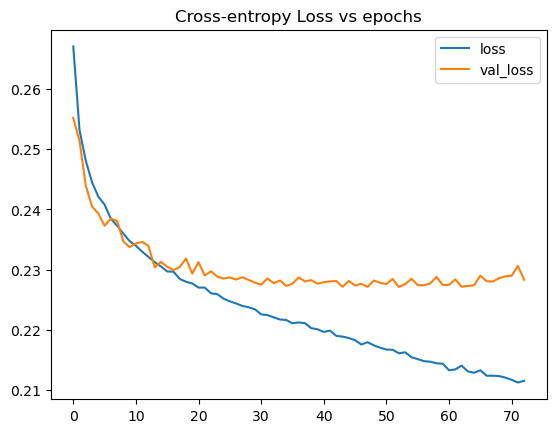

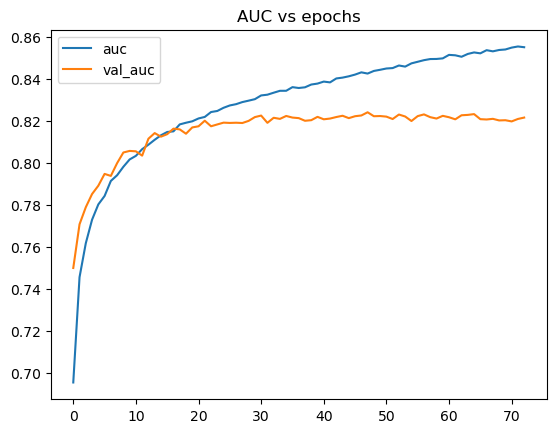

In [40]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(title='Cross-entropy Loss vs epochs')
history_df[['auc', 'val_auc']].plot(title='AUC vs epochs')
print(f"Best validation AUC: {history_df['val_auc'].max()}")

In [41]:
dev_predictions_proba = best_model.predict(X_dev)
dev_predictions = (dev_predictions_proba > 0.5).astype('int')
keras_accuracy = accuracy_score(Y_dev, dev_predictions)
keras_auc = best_model.evaluate(X_dev, Y_dev)[1]
print('Keras AUC:', keras_auc)

2220/2220 [==============================] - 7s 3ms/step - loss: 0.2271 - auc: 0.8242
Keras AUC: 0.8241652846336365


In [42]:
results.append(['Keras', 'Multilayer Perceptron', best_hps.values, keras_accuracy, keras_auc])

# 7 - TensorFlow

Convert the data to tensors.

In [43]:
X_train_tf, Y_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32), tf.convert_to_tensor(Y_train, dtype=tf.float32)
X_dev_tf, Y_dev_tf = tf.convert_to_tensor(X_dev, dtype=tf.float32), tf.convert_to_tensor(Y_dev, dtype=tf.float32)

Shuffle the data and split it into batches.

In [44]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tf, Y_train_tf))
train_dataset = train_dataset.shuffle(buffer_size=X_train.shape[0]).batch(BATCH_SIZE)
dev_dataset = tf.data.Dataset.from_tensor_slices((X_dev_tf, Y_dev_tf))
dev_dataset = dev_dataset.shuffle(buffer_size=X_dev.shape[0]).batch(BATCH_SIZE)

Define the log loss function (or binary cross-entropy).

In [45]:
def log_loss(y_pred, y):
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
    return tf.reduce_mean(loss)

Define the weight initialization funtion.

In [46]:
def xavier_init(shape):
    in_dim, out_dim = shape
    limit = tf.sqrt(6.) / tf.sqrt(tf.cast(in_dim + out_dim, tf.float32))
    weights = tf.random.uniform(shape, minval=-limit, maxval=limit)
    return weights

Define the dense and dropout layers.

In [47]:
class Dense(tf.Module):
    def __init__(self, out_dim, initializer=xavier_init, activation=tf.identity):
        self.out_dim = out_dim
        self.initializer = initializer
        self.activation = activation
        self.built = False

    def __call__(self, x, training=True):
        if not self.built:
            self.in_dim = x.shape[1]
            self.w = tf.Variable(self.initializer((self.in_dim, self.out_dim)))
            self.b = tf.Variable(tf.zeros((self.out_dim,)))
            self.built = True
        z = tf.add(tf.matmul(x, self.w), self.b)
        return self.activation(z)


class Dropout(tf.Module):
    def __init__(self, rate):
        self.rate = rate

    def __call__(self, x, training=True):
        if training:
            return tf.nn.dropout(x, self.rate)
        return x

Define our model as a series of fully-connected layers.

In [48]:
class MLP(tf.Module):
    def __init__(self, layers):
        self.layers = layers

    @tf.function
    def __call__(self, x, training=True):
        for layer in self.layers:
            x = layer(x, training=training)
        if training:
            return x
        return tf.sigmoid(x)

Define a function that creates a Tensorflow model from a dictionary containing hyperparameters.

In [49]:
def build_tf_model(hps):
    layers = []
    for i in range(hps['num_hidden_layers']):
        layers.append(Dense(hps[f'units_{i + 1}'], activation=tf.nn.relu))
        layers.append(Dropout(hps[f'dropout_rate_{i + 1}']))
    layers.append(Dense(1))
    tf_model = MLP(layers)
    return tf_model

Use the best hyperparameters found earlier.

In [50]:
tf_model = build_tf_model(best_hps.values)

Train the model.

In [51]:
def train_iteration(model, x_batch, y_batch, optimizer, loss_func):
    with tf.GradientTape() as tape:
        y_pred = model(x_batch)
        y_pred = tf.squeeze(y_pred, axis=1)
        loss = loss_func(y_pred, y_batch)
    gradients = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(gradients, model.variables))
    return loss

def dev_iteration(model, x_batch, y_batch, loss_func):
    y_pred = model(x_batch)
    y_pred = tf.squeeze(y_pred, axis=1)
    loss = loss_func(y_pred, y_batch)
    return loss

def train_tf_model(model, train_datset, dev_dataset, optimizer, epochs, loss_func):
    train_losses, dev_losses = [], []
    for epoch in range(epochs):
        train_batch_losses, dev_batch_losses = [], []
        for x_batch, y_batch in train_dataset:
            train_batch_loss = train_iteration(model, x_batch, y_batch, optimizer, loss_func)
            train_batch_losses.append(train_batch_loss)
        for x_batch, y_batch in dev_dataset:
            dev_batch_loss = dev_iteration(model, x_batch, y_batch, loss_func)
            dev_batch_losses.append(dev_batch_loss)
        train_loss = tf.reduce_mean(train_batch_losses)
        dev_loss = tf.reduce_mean(dev_batch_losses)
        print(f"Epoch {epoch + 1}/{epochs} - Training loss: {train_loss:.4f}, Validation loss: {dev_loss:.4f}")
        train_losses.append(train_loss)
        dev_losses.append(dev_loss)
    return train_losses, dev_losses

In [52]:
LEARNING_RATE = best_hps.values['lr']
EPOCHS = early_stopping.best_epoch

train_losses, dev_losses = train_tf_model(tf_model, train_dataset, dev_dataset, Adam(learning_rate=LEARNING_RATE), EPOCHS, log_loss)

2023-06-21 17:22:13.642529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [284152,104]
	 [[{{node Placeholder/_0}}]]
2023-06-21 17:22:46.784462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [71038,104]
	 [[{{node Placeholder/_0}}]]


Epoch 1/47 - Training loss: 0.2664, Validation loss: 0.2563
Epoch 2/47 - Training loss: 0.2526, Validation loss: 0.2504
Epoch 3/47 - Training loss: 0.2480, Validation loss: 0.2481
Epoch 4/47 - Training loss: 0.2446, Validation loss: 0.2453
Epoch 5/47 - Training loss: 0.2421, Validation loss: 0.2429
Epoch 6/47 - Training loss: 0.2398, Validation loss: 0.2417
Epoch 7/47 - Training loss: 0.2383, Validation loss: 0.2402
Epoch 8/47 - Training loss: 0.2372, Validation loss: 0.2388
Epoch 9/47 - Training loss: 0.2352, Validation loss: 0.2394
Epoch 10/47 - Training loss: 0.2347, Validation loss: 0.2384
Epoch 11/47 - Training loss: 0.2340, Validation loss: 0.2384
Epoch 12/47 - Training loss: 0.2327, Validation loss: 0.2373
Epoch 13/47 - Training loss: 0.2320, Validation loss: 0.2396
Epoch 14/47 - Training loss: 0.2311, Validation loss: 0.2383
Epoch 15/47 - Training loss: 0.2300, Validation loss: 0.2364
Epoch 16/47 - Training loss: 0.2299, Validation loss: 0.2355
Epoch 17/47 - Training loss: 0.22

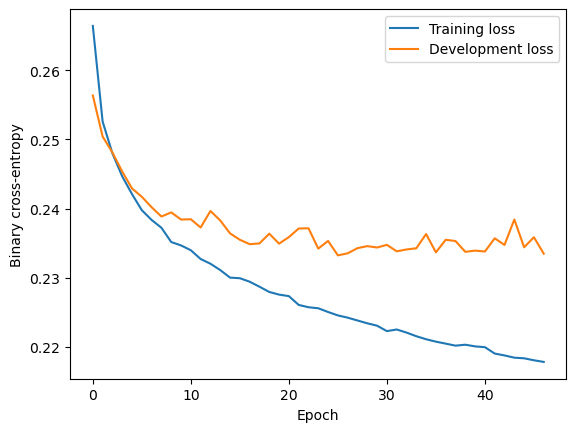

In [53]:
plt.plot(train_losses, label='Training loss')
plt.plot(dev_losses, label='Development loss')
plt.xlabel('Epoch')
plt.ylabel('Binary cross-entropy')
plt.legend();

In [54]:
dev_predictions_proba = tf_model(X_dev_tf, training=False)
dev_predictions = (dev_predictions_proba > 0.5).numpy().astype('int')
tensorflow_auc = roc_auc_score(Y_dev, dev_predictions_proba)
print('Tensorflow AUC:', tensorflow_auc)
tensorflow_accuracy = accuracy_score(Y_dev, dev_predictions)
results.append(['Tensorflow', 'Multilayer Perceptron', best_hps.values, tensorflow_accuracy, tensorflow_auc])

Tensorflow AUC: 0.8239576913851479


# 8 - Numpy

In [55]:
from multilayerperceptron import MultiLayerPerceptron

In [56]:
Y_train = Y_train.to_numpy().reshape(-1, 1)
Y_dev = Y_dev.to_numpy().reshape(-1, 1)

Set the models's architecture (the size, activation, and dropout rate of each layer).

In [57]:
input_layer_size = X_train.shape[1]

architecture = [
    [input_layer_size, None, 0]
]

num_hidden_layers = best_hps.values['num_hidden_layers']
for i in range(1, num_hidden_layers + 1):
    num_units = best_hps.values[f'units_{i}']
    dropout_rate = best_hps.values[f'dropout_rate_{i}']
    layer = [num_units, 'relu', dropout_rate]
    architecture.append(layer)
architecture.append([1, 'sigmoid', 0])

Train the model.

epoch 1/30: 100%|██████████| 555/555 [00:40<00:00, 13.66it/s]


epoch 1/30 - loss: 0.4220 - val_loss: 0.3663


epoch 2/30: 100%|██████████| 555/555 [00:39<00:00, 13.97it/s]


epoch 2/30 - loss: 0.3322 - val_loss: 0.3327


epoch 3/30: 100%|██████████| 555/555 [00:38<00:00, 14.53it/s]


epoch 3/30 - loss: 0.3222 - val_loss: 0.3215


epoch 4/30: 100%|██████████| 555/555 [00:37<00:00, 14.72it/s]


epoch 4/30 - loss: 0.3173 - val_loss: 0.3148


epoch 5/30: 100%|██████████| 555/555 [00:37<00:00, 14.66it/s]


epoch 5/30 - loss: 0.3132 - val_loss: 0.3096


epoch 6/30: 100%|██████████| 555/555 [00:37<00:00, 14.87it/s]


epoch 6/30 - loss: 0.3093 - val_loss: 0.3051


epoch 7/30: 100%|██████████| 555/555 [00:36<00:00, 15.00it/s]


epoch 7/30 - loss: 0.3060 - val_loss: 0.3012


epoch 8/30: 100%|██████████| 555/555 [00:37<00:00, 14.75it/s]


epoch 8/30 - loss: 0.3032 - val_loss: 0.2978


epoch 9/30: 100%|██████████| 555/555 [00:37<00:00, 14.83it/s]


epoch 9/30 - loss: 0.3006 - val_loss: 0.2948


epoch 10/30: 100%|██████████| 555/555 [00:37<00:00, 14.68it/s]


epoch 10/30 - loss: 0.2982 - val_loss: 0.2922


epoch 11/30: 100%|██████████| 555/555 [00:37<00:00, 14.81it/s]


epoch 11/30 - loss: 0.2960 - val_loss: 0.2898


epoch 12/30: 100%|██████████| 555/555 [00:36<00:00, 15.14it/s]


epoch 12/30 - loss: 0.2938 - val_loss: 0.2876


epoch 13/30: 100%|██████████| 555/555 [00:37<00:00, 14.77it/s]


epoch 13/30 - loss: 0.2928 - val_loss: 0.2858


epoch 14/30: 100%|██████████| 555/555 [00:37<00:00, 14.88it/s]


epoch 14/30 - loss: 0.2906 - val_loss: 0.2840


epoch 15/30: 100%|██████████| 555/555 [00:36<00:00, 15.01it/s]


epoch 15/30 - loss: 0.2896 - val_loss: 0.2825


epoch 16/30: 100%|██████████| 555/555 [00:37<00:00, 14.72it/s]


epoch 16/30 - loss: 0.2883 - val_loss: 0.2812


epoch 17/30: 100%|██████████| 555/555 [00:36<00:00, 15.06it/s]


epoch 17/30 - loss: 0.2868 - val_loss: 0.2799


epoch 18/30: 100%|██████████| 555/555 [00:42<00:00, 13.08it/s]


epoch 18/30 - loss: 0.2857 - val_loss: 0.2789


epoch 19/30: 100%|██████████| 555/555 [00:36<00:00, 15.38it/s]


epoch 19/30 - loss: 0.2850 - val_loss: 0.2780


epoch 20/30: 100%|██████████| 555/555 [00:33<00:00, 16.56it/s]


epoch 20/30 - loss: 0.2839 - val_loss: 0.2771


epoch 21/30: 100%|██████████| 555/555 [00:35<00:00, 15.54it/s]


epoch 21/30 - loss: 0.2830 - val_loss: 0.2764


epoch 22/30: 100%|██████████| 555/555 [00:36<00:00, 15.37it/s]


epoch 22/30 - loss: 0.2824 - val_loss: 0.2757


epoch 23/30: 100%|██████████| 555/555 [00:41<00:00, 13.41it/s]


epoch 23/30 - loss: 0.2819 - val_loss: 0.2751


epoch 24/30: 100%|██████████| 555/555 [00:34<00:00, 16.01it/s]


epoch 24/30 - loss: 0.2814 - val_loss: 0.2746


epoch 25/30: 100%|██████████| 555/555 [00:34<00:00, 15.98it/s]


epoch 25/30 - loss: 0.2802 - val_loss: 0.2741


epoch 26/30: 100%|██████████| 555/555 [00:42<00:00, 13.21it/s]


epoch 26/30 - loss: 0.2798 - val_loss: 0.2736


epoch 27/30: 100%|██████████| 555/555 [00:41<00:00, 13.48it/s]


epoch 27/30 - loss: 0.2796 - val_loss: 0.2732


epoch 28/30: 100%|██████████| 555/555 [00:37<00:00, 14.84it/s]


epoch 28/30 - loss: 0.2789 - val_loss: 0.2728


epoch 29/30: 100%|██████████| 555/555 [00:36<00:00, 15.33it/s]


epoch 29/30 - loss: 0.2788 - val_loss: 0.2725


epoch 30/30: 100%|██████████| 555/555 [00:38<00:00, 14.25it/s]


epoch 30/30 - loss: 0.2780 - val_loss: 0.2721


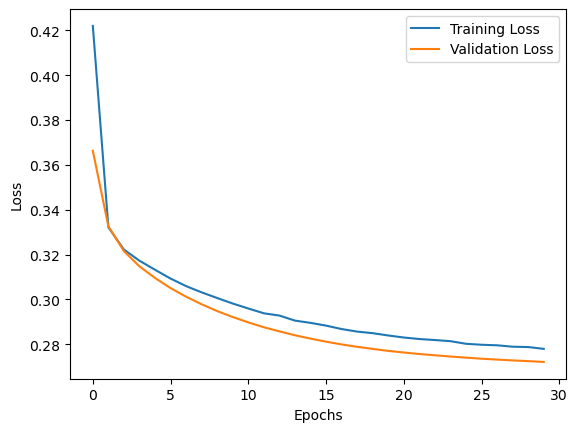

In [58]:
mlp = MultiLayerPerceptron(architecture)

J_train_history, J_valid_history = mlp.fit(X_train, Y_train, X_dev,
                                            Y_dev, 1e-3, 30, BATCH_SIZE)

# Plot the learning curves
plt.plot(J_train_history, label='Training Loss')
plt.plot(J_valid_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

In [59]:
dev_predictions_proba = mlp.predict(X_dev)
dev_predictions = (dev_predictions_proba > 0.5).astype('int')

numpy_auc = roc_auc_score(Y_dev, dev_predictions_proba)
print('Numpy AUC:', numpy_auc)
numpy_accuracy = accuracy_score(Y_dev, dev_predictions)
results.append(['Numpy', 'Multilayer Perceptron', best_hps.values, numpy_accuracy, numpy_auc])

Numpy AUC: 0.655145289749872


Print the results table.

In [60]:
results_table = pd.DataFrame(results, columns=columns)
results_table

,Library,Algorithm,Hyperparameters,Accuracy,AUC
0,-,Baseline naive classifier,-,0.918565,0.500000
1,Scikit-learn,Random Forest,"{'max_depth': 16, 'max_features': 'sqrt', 'n_e...",0.919325,0.832324
2,Scikit-learn,Multilayer Perceptron,"hidden_layer_sizes=(50,), max_iter=15",0.917917,0.804197
3,Keras,Multilayer Perceptron,"{'units_1': 550, 'dropout_rate_1': 0.4, 'num_h...",0.919353,0.824165
4,Tensorflow,Multilayer Perceptron,"{'units_1': 550, 'dropout_rate_1': 0.4, 'num_h...",0.919086,0.823958
5,Numpy,Multilayer Perceptron,"{'units_1': 550, 'dropout_rate_1': 0.4, 'num_h...",0.918171,0.655145


# 9 - Make predictions on the test set

In [61]:
del(X_train)
del(X_dev)
del(Y_train)
del(Y_dev)
del(X_train_tf)
del(Y_train_tf)
del(X_dev_tf)
del(Y_dev_tf)

Preprocessing.

In [62]:
X_test = pd.read_csv('data/bank_data_test.csv', index_col='ID')
X_test.drop(columns=useless_cols + ['TARGET'], inplace=True)
index_test = X_test.index

X_test_categorical = X_test.select_dtypes(include=["object_"])
X_test.drop(columns=categorical_cols, inplace=True)
X_test_categorical = X_test_categorical.apply(lambda c: c.str.lower())
X_test_categorical['CLNT_TRUST_RELATION'].replace(ru_to_en, inplace=True)

X_test.fillna(medians, inplace=True)

X_test_categorical_encoded = pd.DataFrame()
for col in categorical_cols:
    X_test_categorical_encoded[col] = X_test_categorical[col].astype(pd.CategoricalDtype(categories=categories[col]))
    X_test_categorical_encoded[col] = X_test_categorical_encoded[col].cat.codes

del(X_test_categorical)

X_test = pd.concat([X_test, X_test_categorical_encoded], axis=1)
del(X_test_categorical_encoded)

X_test = scaler.transform(X_test)

Save the final predictions to a csv file.

In [63]:
test_predictions = best_model.predict(X_test)
pd.DataFrame(test_predictions, index=index_test, columns=['TARGET']).to_csv('final_predictions.csv')

2775/2775 [==============================] - 6s 2ms/step
